<a href="https://colab.research.google.com/github/AbrahamSilva27/Apps_UDLAP/blob/main/329_Detectron2_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/JIPbilHxFbI

# An introduction to Detectron2 <p>
Using pre-trained models for instance and panoptic segmentation

Install the Detectron2 library

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.8 ; cuda:  cu126
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
#from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Read an image

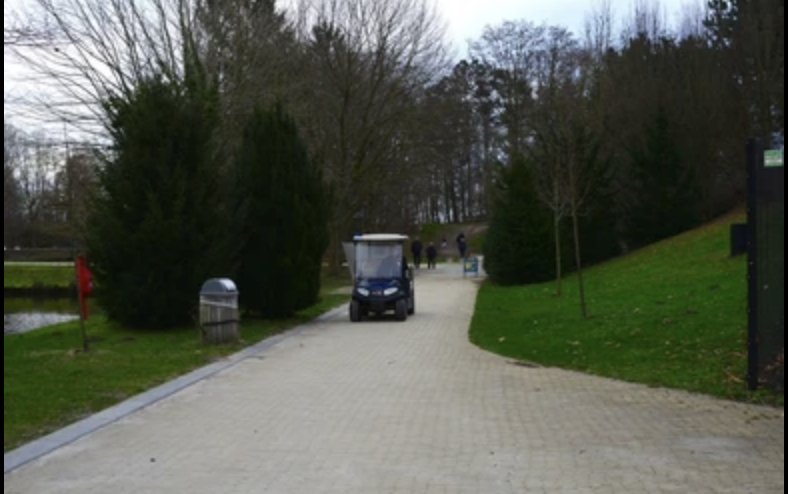

In [4]:
my_new_image = cv2.imread("/content/Captura de pantalla 2025-11-11 a la(s) 5.25.00 p.m..png")
cv2_imshow(my_new_image)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Keypoint detection model** <p>
Keypoints are specific locations or landmarks in an image that are distinctive and informative. These keypoints are selected because they represent significant variations in the local image region and can be reliably detected and matched across different images.

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


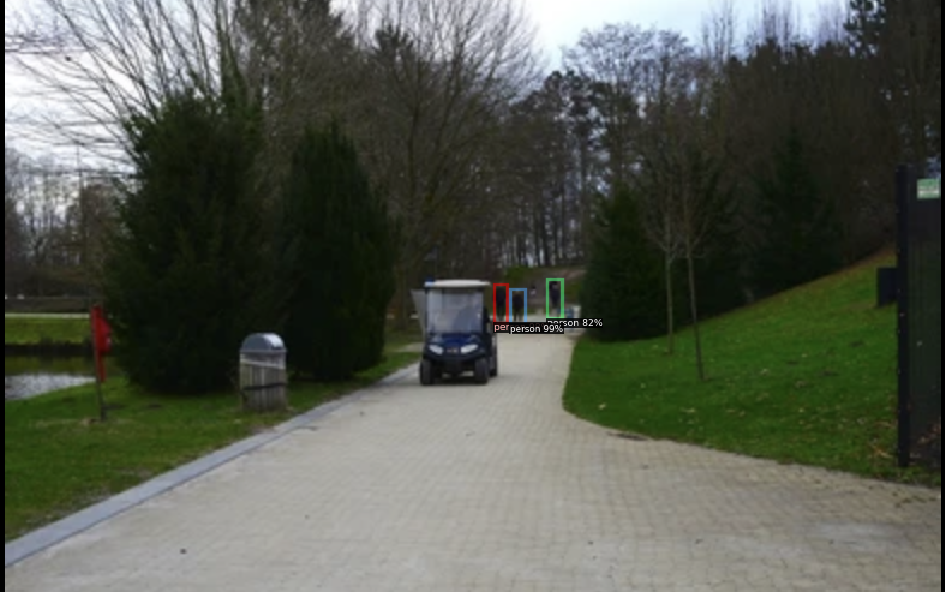

In [5]:
# Inference with a keypoint detection model
cfg_keypoint = get_cfg()   # get a fresh new config
cfg_keypoint.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg_keypoint.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_keypoint)
outputs = predictor(my_new_image)
v = Visualizer(my_new_image[:,:,::-1], MetadataCatalog.get(cfg_keypoint.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Instance Segmentation** <p>
Instance segmentation is a computer vision task that involves identifying and delineating individual objects within an image by assigning a unique mask to each object instance.

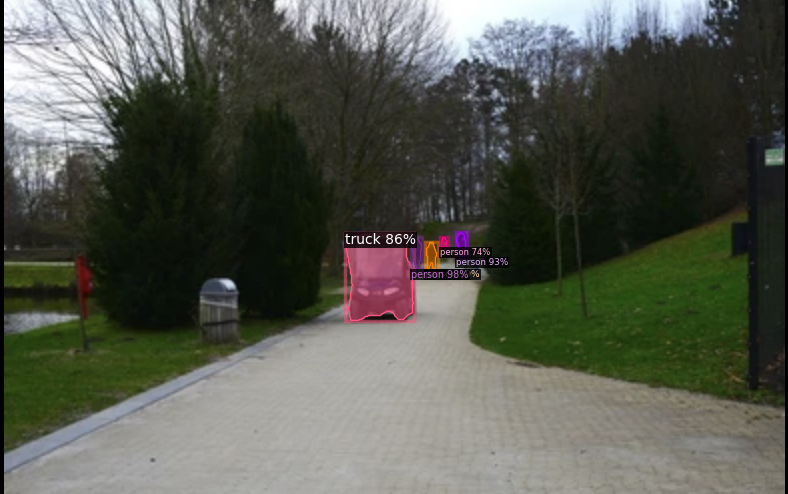

In [6]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(my_new_image)

v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**
<p>
Panoptic segmentation is a computer vision task that combines instance segmentation and semantic segmentation to label every pixel in an image with both a class category and a unique instance ID.

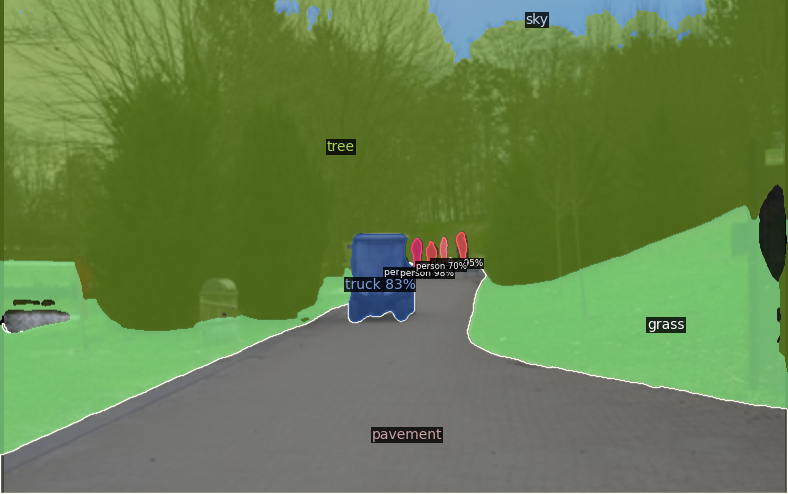

In [7]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(my_new_image)["panoptic_seg"]
v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

🎯 PANOPTIC SEGMENTATION CON PESOS LOCALES
📁 VERIFICANDO PESOS LOCALES:
   ✅ panoptic_r101: /content/model_final_cafdb1.pkl (248.5 MB)

🌈 PANOPTIC SEGMENTATION (Pesos locales)
----------------------------------------
   📂 Pesos: /content/model_final_cafdb1.pkl
   ✅ Segmentos: 9 total
   ✅ Instancias: 5, Semánticos: 4

   🏷️  CATEGORÍAS DETECTADAS:
       1. person          (thing)
       2. person          (thing)
       3. person          (thing)
       4. truck           (thing)
       5. person          (thing)
       6. tree            (stuff)
       7. sky             (stuff)
       8. pavement        (stuff)
       9. grass           (stuff)

   🎨 Generando visualización...


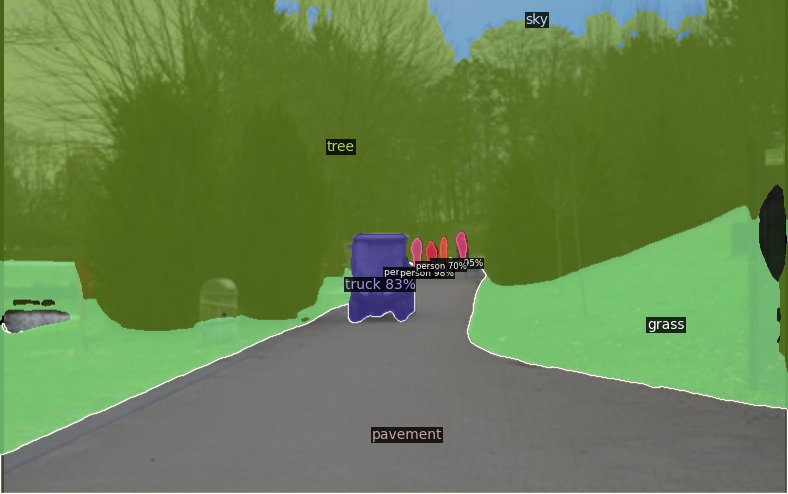


   ✅ Panoptic Segmentation completado exitosamente

🎉 RESUMEN EJECUCIÓN PANOPTIC SEGMENTATION
📊 ESTADO:
   • panoptic_r101: ✅ EJECUTADO (248.5 MB)

💡 INFORMACIÓN:
   • Modelo: panoptic_fpn_R_101_3x
   • Pesos: locales (/content/model_final_cafdb1.pkl)
   • No se requiere conexión a internet
   • Configuración optimizada aplicada


In [11]:
# =============================================================================
# PANOPTIC SEGMENTATION SOLAMENTE - CON PESOS LOCALES
# =============================================================================

print("🎯 PANOPTIC SEGMENTATION CON PESOS LOCALES")
print("=" * 50)

# Verificar que los pesos existen
import os
from pathlib import Path

# Mapeo de pesos locales - SOLO PANOPTIC
local_weights = {
    "panoptic_r101": "/content/model_final_cafdb1.pkl"
}

print("📁 VERIFICANDO PESOS LOCALES:")
for model_name, weight_path in local_weights.items():
    if os.path.exists(weight_path):
        file_size = os.path.getsize(weight_path) / (1024 * 1024)  # Tamaño en MB
        print(f"   ✅ {model_name}: {weight_path} ({file_size:.1f} MB)")
    else:
        print(f"   ❌ {model_name}: {weight_path} - NO ENCONTRADO")

print()

# -----------------------------------------------------------------------------
# PANOPTIC SEGMENTATION CON PESOS LOCALES
# -----------------------------------------------------------------------------
print("🌈 PANOPTIC SEGMENTATION (Pesos locales)")
print("-" * 40)

try:
    # Configuración del modelo
    cfg_pan = get_cfg()
    cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))

    # Configuraciones optimizadas para mejores resultados
    cfg_pan.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Umbral para más detecciones
    cfg_pan.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
    cfg_pan.INPUT.MIN_SIZE_TEST = 800
    cfg_pan.INPUT.MAX_SIZE_TEST = 1333

    # USAR PESOS LOCALES
    cfg_pan.MODEL.WEIGHTS = local_weights["panoptic_r101"]
    print(f"   📂 Pesos: {cfg_pan.MODEL.WEIGHTS}")

    # Crear predictor
    predictor = DefaultPredictor(cfg_pan)

    # Realizar inferencia
    panoptic_seg, segments_info = predictor(my_new_image)["panoptic_seg"]

    # Análisis de resultados
    things_count = sum(1 for seg in segments_info if seg["isthing"])
    stuff_count = sum(1 for seg in segments_info if not seg["isthing"])

    print(f"   ✅ Segmentos: {len(segments_info)} total")
    print(f"   ✅ Instancias: {things_count}, Semánticos: {stuff_count}")

    # Mostrar categorías detectadas
    metadata = MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0])
    print(f"\n   🏷️  CATEGORÍAS DETECTADAS:")
    for i, segment in enumerate(segments_info[:10]):  # Mostrar primeras 10
        category_id = segment["category_id"]
        is_thing = segment["isthing"]
        category_name = metadata.stuff_classes[category_id] if not is_thing else metadata.thing_classes[category_id]
        score = segment.get("score", "N/A")
        print(f"      {i+1:2d}. {category_name:15} ({'thing' if is_thing else 'stuff'})")

    if len(segments_info) > 10:
        print(f"      ... y {len(segments_info) - 10} más")

    # Visualizar resultados
    print("\n   🎨 Generando visualización...")
    v = Visualizer(my_new_image[:, :, ::-1], metadata, scale=1.0)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    cv2_imshow(out.get_image()[:, :, ::-1])

    print("\n   ✅ Panoptic Segmentation completado exitosamente")

except Exception as e:
    print(f"   ❌ Error en Panoptic Segmentation: {e}")
    import traceback
    traceback.print_exc()

# -----------------------------------------------------------------------------
# RESUMEN FINAL
# -----------------------------------------------------------------------------
print("\n" + "=" * 50)
print("🎉 RESUMEN EJECUCIÓN PANOPTIC SEGMENTATION")
print("=" * 50)

print("📊 ESTADO:")
for model_name, weight_path in local_weights.items():
    if os.path.exists(weight_path):
        status = "✅ EJECUTADO"
        file_size = os.path.getsize(weight_path) / (1024 * 1024)
        print(f"   • {model_name}: {status} ({file_size:.1f} MB)")
    else:
        print(f"   • {model_name}: ❌ NO EJECUTADO")

print("\n💡 INFORMACIÓN:")
print("   • Modelo: panoptic_fpn_R_101_3x")
print("   • Pesos: locales (/content/model_final_cafdb1.pkl)")
print("   • No se requiere conexión a internet")
print("   • Configuración optimizada aplicada")

Now that we know the model is working on a natural image, let us test on a scientific image.

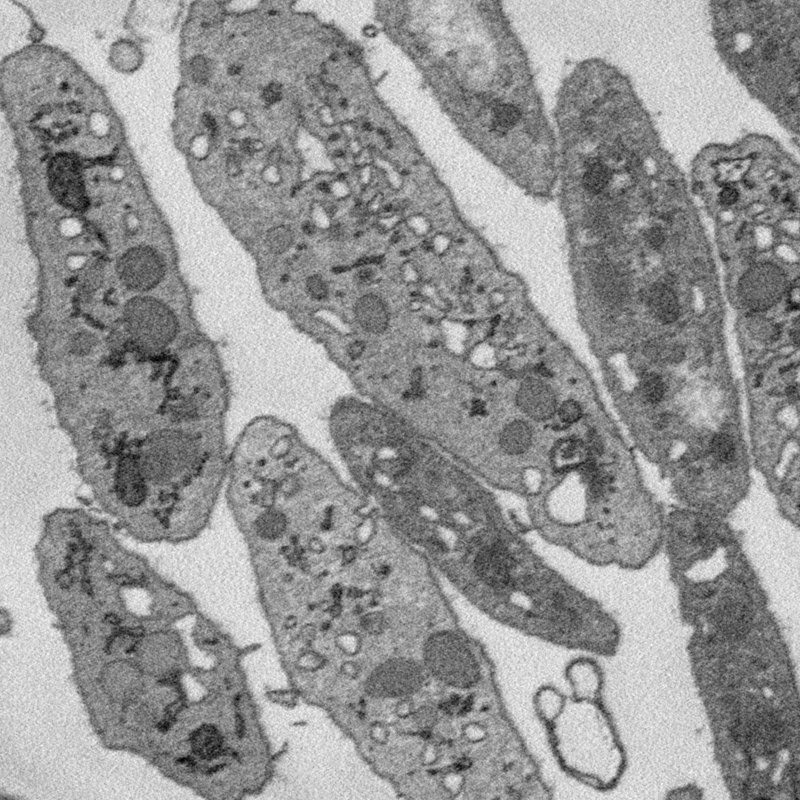

In [ ]:
sci_im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test/3D-EM-platelet-train02.png")
cv2_imshow(sci_im)

Let us make some predictions. Remember that the model mask_rcnn_R_50_FPN_3x has no idea about our sample and did not get trained on cells or mitochondria or on any scientific images.

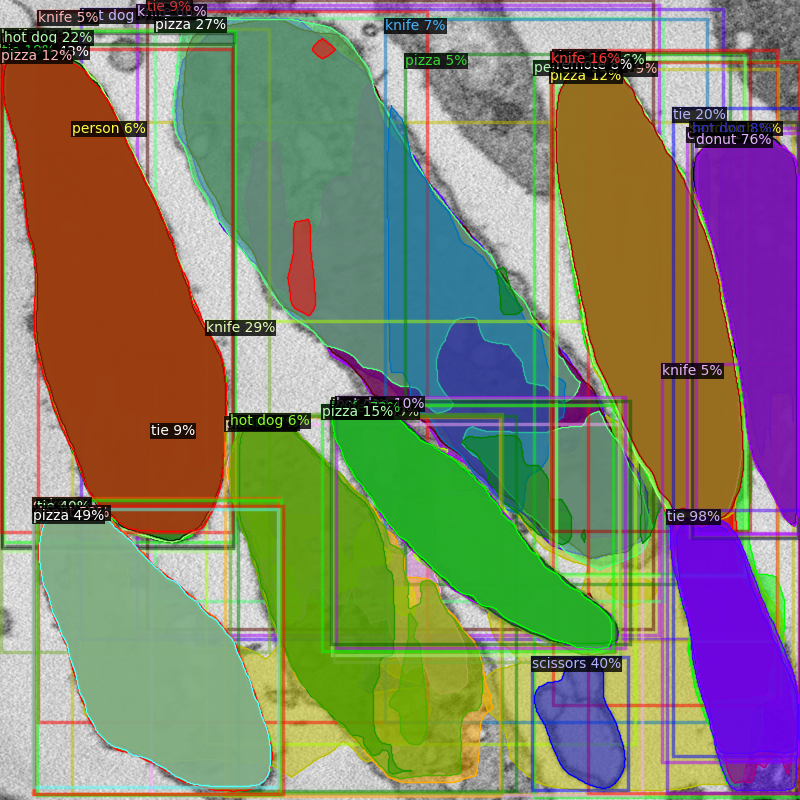

In [ ]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

**We need to train a custom model using our own data and labels. (Next tutorial)**